# <ins> HeartRate Detection Algorithm </ins>

In [1]:
# Project imports
import sys
import os

# Add the parent directory to the system path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from HeartRateMeasurementAlgorithm import merge_ranges, detectMotion, generateValidPPGDataCSVFiles, measureHeartRate

CSV_FILE_NAME = '2023-05-01-001S-16-32-10-S'
CSV_FILE_EXT = '.csv'
CSV_FILE_PATH = CSV_FILE_NAME + CSV_FILE_EXT

### 1. Detect Motion Ranges in PPG CSV File

A_x_high_fluctuation_ranges:  []
A_y_high_fluctuation_ranges:  []
A_z_high_fluctuation_ranges:  []
ppg_data_high_fluctuation_ranges:  []
Motion Ranges:  []


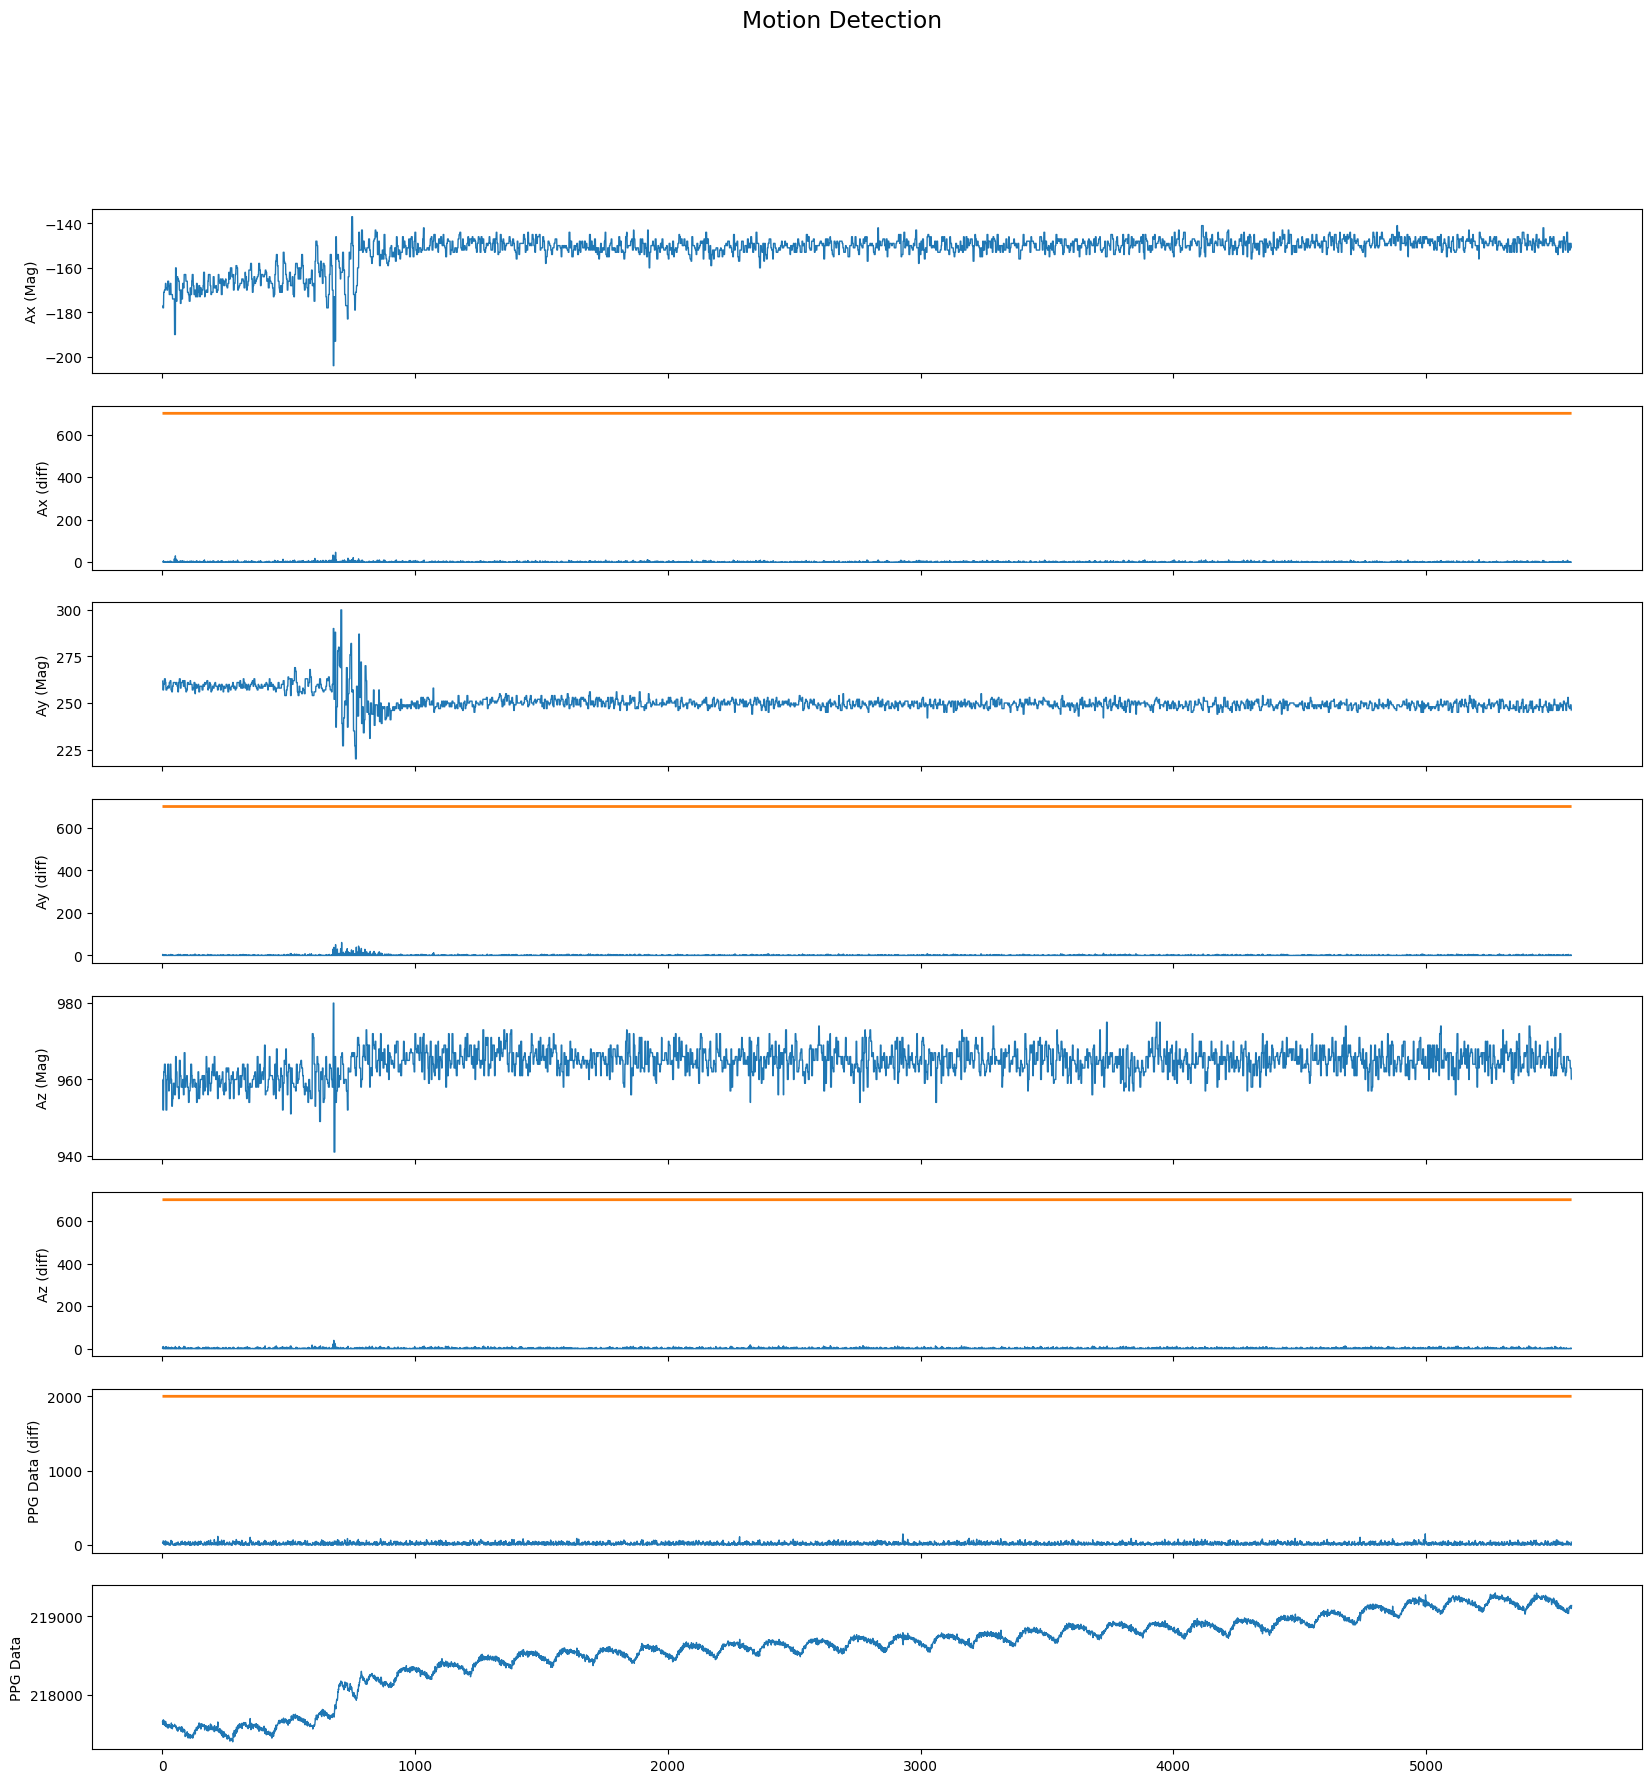

In [2]:

motionRanges = detectMotion(CSV_FILE_PATH)
print("Motion Ranges: ", motionRanges)

### 2. Slice CSV File Based on Motion Ranges

In [3]:
valid_csv_files = generateValidPPGDataCSVFiles(CSV_FILE_PATH, motionRanges, CSV_FILE_NAME)
print(valid_csv_files) 

Motion Ranges:  []
No Motion Rages:  [(0, 5576)]
Range: (0, 5576) --> ValidCSVFiles/2023-05-01-001S-16-32-10-S-P0.csv
['ValidCSVFiles/2023-05-01-001S-16-32-10-S-P0.csv']


### 3. HeartRate Measurement  

3.2028519279369734
ValidCSVFiles/2023-05-01-001S-16-32-10-S-P0.csv -> HeartRate: 73.15761161915007


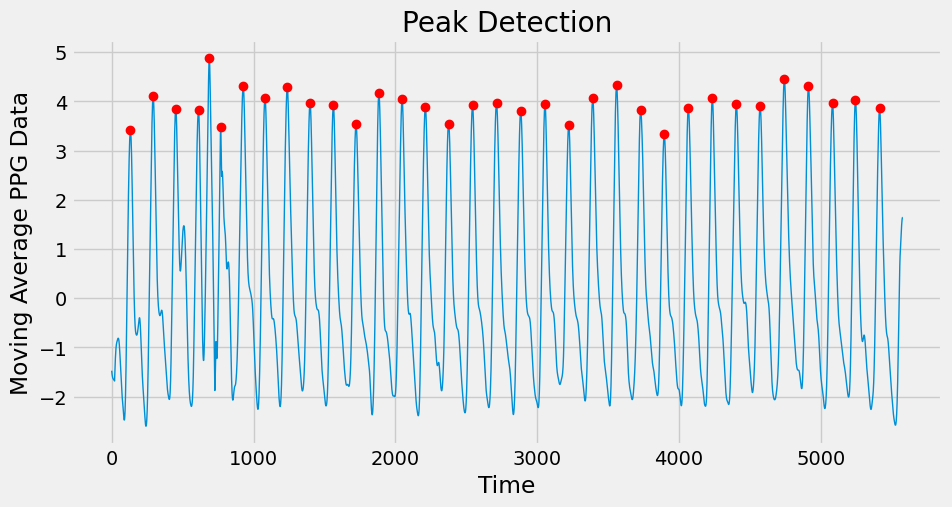

In [4]:
#Measure Heart Rate For Raw CSV File.
# hr = measureHeartRate(CSV_FILE_PATH, plot_save = False, no_skip_rows=15)
# print(f"{CSV_FILE_PATH} -> HeartRate: {hr}")
# Measaure Heart Rate For All Valid CSV Files 
for valid_csv_file in valid_csv_files:
    try:
        hr = measureHeartRate(valid_csv_file, plot_save = True)
    except:
        hr = "Error"
    print(f"{valid_csv_file} -> HeartRate: {hr}")
# print("HeartRate: ", measureHeartRate('2023-05-10-001S-22-05-32-S.csv'))
